In [15]:
# Cell 1: Setup and Imports
import json
import sys
from pathlib import Path
from collections import defaultdict
import pandas as pd
from typing import List, Dict, Any
# Add src to path
sys.path.append('src')

from seqeval.metrics import (
    precision_score, recall_score, f1_score,
    classification_report, accuracy_score
)

from inference import BusNERInference
from constants.entity_labels import ENTITY_LABELS

print("✅ Imports successful!")

✅ Imports successful!


In [16]:
# Cell 2: Configuration — Evaluation on HELD-OUT eval set
from datasets import Dataset

MODEL_PATH = "models/bus_ner_transformer_v5"
USE_ONNX = False

# ✅ Point to the new dedicated evaluation data (not training data)
TEST_DATA_PATH = "data/evaluation_data_bio.json"

# Load eval data directly — no splitting needed, it's all test data
with open(TEST_DATA_PATH, 'r', encoding='utf-8') as f:
    test_data = json.load(f)

print(f"📊 Eval samples loaded: {len(test_data)}")
print(f"✅ Using held-out evaluation set: {TEST_DATA_PATH}")

📊 Eval samples loaded: 5000
✅ Using held-out evaluation set: data/evaluation_data_bio.json


In [17]:
# Cell 3: Helper Functions
def extract_entities_from_spans(text: str, entities: List[List[int]]) -> Dict[str, List[str]]:
    """Convert span-based entities to label-based dictionary."""
    result = {label: [] for label in ENTITY_LABELS}
    
    for start, end, label in entities:
        entity_text = text[start:end].strip()
        if entity_text and label in result:
            result[label].append(entity_text)
    
    return result

def convert_to_bio_format(text: str, entities: Dict[str, List[str]]) -> List[str]:
    """Convert entity dictionary to BIO tag sequence."""
    words = text.split()
    tags = ["O"] * len(words)
    
    # Build character-to-word mapping
    char_to_word = {}
    char_pos = 0
    for word_idx, word in enumerate(words):
        for i in range(len(word)):
            char_to_word[char_pos + i] = word_idx
        char_pos += len(word) + 1
    
    # Mark entities
    for label, values in entities.items():
        for value in values:
            start_idx = text.find(value)
            if start_idx != -1:
                end_idx = start_idx + len(value)
                word_indices = set()
                for char_idx in range(start_idx, end_idx):
                    if char_idx in char_to_word:
                        word_indices.add(char_to_word[char_idx])
                
                if word_indices:
                    sorted_indices = sorted(word_indices)
                    for i, word_idx in enumerate(sorted_indices):
                        if i == 0:
                            tags[word_idx] = f"B-{label}"
                        else:
                            tags[word_idx] = f"I-{label}"
    
    return tags

print("✅ Helper functions defined!")

✅ Helper functions defined!


In [18]:
# Cell 4: Load Model
print("🔄 Loading model...")
ner = BusNERInference(MODEL_PATH, use_onnx=USE_ONNX)
print("✅ Model loaded!")

🔄 Loading model...
Loaded PyTorch model from: models/bus_ner_transformer_v5
Device: cpu
Number of labels: 45
✅ Model loaded!


In [19]:
# Cell 5: Run Evaluation (SIMPLER - uses BIO tags directly)
print("🔄 Running evaluation...")
print("=" * 60)

# Load label mappings
with open('data/id2label.json', 'r') as f:
    id2label_dict = json.load(f)
    id2label = {int(k): v for k, v in id2label_dict.items()}

true_labels_list = []
pred_labels_list = []
entity_metrics = defaultdict(lambda: {"tp": 0, "fp": 0, "fn": 0})

for i, sample in enumerate(test_data):
    if (i + 1) % 50 == 0:
        print(f"  Processed {i+1}/{len(test_data)} samples...")
    
    # Reconstruct text from tokens
    tokens = sample["tokens"]
    text = " ".join(tokens)
    
    # Get ground truth BIO tags (convert IDs to labels)
    true_ner_tag_ids = sample["ner_tags"]
    true_bio = [id2label.get(tag_id, "O") for tag_id in true_ner_tag_ids]
    
    # Get predictions from model
    pred_entities = ner.extract(text)
    
    # Convert predictions to BIO format
    # Simple approach: match tokens to predicted entities
    pred_bio = ["O"] * len(tokens)
    
    for label, values in pred_entities.items():
        for value in values:
            value_tokens = value.split()
            # Try to find this entity in the token sequence
            for j in range(len(tokens) - len(value_tokens) + 1):
                if tokens[j:j+len(value_tokens)] == value_tokens:
                    # Mark as entity
                    for k, token in enumerate(value_tokens):
                        if k == 0:
                            pred_bio[j + k] = f"B-{label}"
                        else:
                            pred_bio[j + k] = f"I-{label}"
                    break
    
    true_labels_list.append(true_bio)
    pred_labels_list.append(pred_bio)
    
    # Extract entities from BIO for per-entity metrics
    def extract_from_bio(tokens, bio_tags):
        entities = {label: [] for label in ENTITY_LABELS}
        current_entity = []
        current_label = None
        
        for token, tag in zip(tokens, bio_tags):
            if tag.startswith("B-"):
                if current_label and current_entity:
                    entities[current_label].append(" ".join(current_entity))
                current_label = tag[2:]
                current_entity = [token]
            elif tag.startswith("I-"):
                label = tag[2:]
                if label == current_label:
                    current_entity.append(token)
                else:
                    if current_label and current_entity:
                        entities[current_label].append(" ".join(current_entity))
                    current_label = label
                    current_entity = [token]
            else:
                if current_label and current_entity:
                    entities[current_label].append(" ".join(current_entity))
                current_label = None
                current_entity = []
        
        if current_label and current_entity:
            entities[current_label].append(" ".join(current_entity))
        
        return entities
    
    true_entities = extract_from_bio(tokens, true_bio)
    pred_entities_dict = extract_from_bio(tokens, pred_bio)
    
    # Per-entity metrics
    for label in ENTITY_LABELS:
        true_set = set(true_entities.get(label, []))
        pred_set = set(pred_entities_dict.get(label, []))
        
        entity_metrics[label]["tp"] += len(true_set & pred_set)
        entity_metrics[label]["fp"] += len(pred_set - true_set)
        entity_metrics[label]["fn"] += len(true_set - pred_set)

print(f"✅ Processed all {len(test_data)} samples!")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


🔄 Running evaluation...
  Processed 50/5000 samples...
  Processed 100/5000 samples...
  Processed 150/5000 samples...
  Processed 200/5000 samples...
  Processed 250/5000 samples...
  Processed 300/5000 samples...
  Processed 350/5000 samples...
  Processed 400/5000 samples...
  Processed 450/5000 samples...
  Processed 500/5000 samples...
  Processed 550/5000 samples...
  Processed 600/5000 samples...
  Processed 650/5000 samples...
  Processed 700/5000 samples...
  Processed 750/5000 samples...
  Processed 800/5000 samples...
  Processed 850/5000 samples...
  Processed 900/5000 samples...
  Processed 950/5000 samples...
  Processed 1000/5000 samples...
  Processed 1050/5000 samples...
  Processed 1100/5000 samples...
  Processed 1150/5000 samples...
  Processed 1200/5000 samples...
  Processed 1250/5000 samples...
  Processed 1300/5000 samples...
  Processed 1350/5000 samples...
  Processed 1400/5000 samples...
  Processed 1450/5000 samples...
  Processed 1500/5000 samples...
  Proc

In [20]:
# Cell 6: Calculate Overall Metrics
precision = precision_score(true_labels_list, pred_labels_list)
recall = recall_score(true_labels_list, pred_labels_list)
f1 = f1_score(true_labels_list, pred_labels_list)
accuracy = accuracy_score(true_labels_list, pred_labels_list)

print("=" * 60)
print("📊 OVERALL METRICS")
print("=" * 60)
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1 Score:  {f1:.4f} ({f1*100:.2f}%)")
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")

📊 OVERALL METRICS
Precision: 0.9583 (95.83%)
Recall:    0.9753 (97.53%)
F1 Score:  0.9667 (96.67%)
Accuracy:  0.9865 (98.65%)


In [21]:
# Cell 7: Per-Entity Metrics Table (NO MATPLOTLIB VERSION)
per_entity_data = []

for label in ENTITY_LABELS:
    tp = entity_metrics[label]["tp"]
    fp = entity_metrics[label]["fp"]
    fn = entity_metrics[label]["fn"]
    
    precision_entity = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall_entity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_entity = 2 * (precision_entity * recall_entity) / (precision_entity + recall_entity) if (precision_entity + recall_entity) > 0 else 0.0
    
    per_entity_data.append({
        "Entity": label,
        "Precision": precision_entity,
        "Recall": recall_entity,
        "F1": f1_entity,
        "Support": tp + fn,
        "TP": tp,
        "FP": fp,
        "FN": fn
    })

# Create DataFrame
df = pd.DataFrame(per_entity_data)
df = df.sort_values("F1", ascending=False)

# Format numbers
df_formatted = df.copy()
for col in ['Precision', 'Recall', 'F1']:
    df_formatted[col] = df_formatted[col].apply(lambda x: f"{x:.4f}")
for col in ['Support', 'TP', 'FP', 'FN']:
    df_formatted[col] = df_formatted[col].apply(lambda x: f"{int(x)}")

print("📈 PER-ENTITY METRICS")
print("=" * 80)
display(df_formatted)

# Also show the numeric version for sorting/filtering
print("\n📊 Numeric version (for analysis):")
display(df)

📈 PER-ENTITY METRICS


,Entity,Precision,Recall,F1,Support,TP,FP,FN
18,ADD_ONS,1.0000,1.0000,1.0000,138,138,0,0
17,DEALS,1.0000,1.0000,1.0000,128,128,0,0
13,AMENITIES,1.0000,0.9924,0.9962,262,260,0,2
8,PICKUP_POINT,0.9847,0.9981,0.9914,517,516,8,1
11,BUS_TYPE,0.9934,0.9837,0.9885,306,301,2,5
21,TRAVELER,0.9956,0.9698,0.9825,232,225,1,7
2,DESTINATION_NAME,0.9829,0.9791,0.9810,4871,4769,83,102
0,SOURCE_NAME,0.9774,0.9780,0.9777,4865,4758,110,107
16,COUPON_CODE,0.9505,1.0000,0.9746,211,211,11,0
12,SEAT_TYPE,0.9563,0.9918,0.9737,486,482,22,4



📊 Numeric version (for analysis):


,Entity,Precision,Recall,F1,Support,TP,FP,FN
18,ADD_ONS,1.000000,1.000000,1.000000,138,138,0,0
17,DEALS,1.000000,1.000000,1.000000,128,128,0,0
13,AMENITIES,1.000000,0.992366,0.996169,262,260,0,2
8,PICKUP_POINT,0.984733,0.998066,0.991354,517,516,8,1
11,BUS_TYPE,0.993399,0.983660,0.988506,306,301,2,5
21,TRAVELER,0.995575,0.969828,0.982533,232,225,1,7
2,DESTINATION_NAME,0.982894,0.979060,0.980973,4871,4769,83,102
0,SOURCE_NAME,0.977403,0.978006,0.977705,4865,4758,110,107
16,COUPON_CODE,0.950450,1.000000,0.974596,211,211,11,0
12,SEAT_TYPE,0.956349,0.991770,0.973737,486,482,22,4


In [22]:
# Cell 8: Detailed Classification Report
print("=" * 60)
print("📋 DETAILED CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(true_labels_list, pred_labels_list))

📋 DETAILED CLASSIFICATION REPORT
                       precision    recall  f1-score   support

              AC_TYPE       0.94      0.94      0.94       794
              ADD_ONS       1.00      1.00      1.00       138
            AMENITIES       1.00      0.99      1.00       262
         ARRIVAL_DATE       0.98      0.80      0.88       227
         ARRIVAL_TIME       0.92      0.94      0.93       341
         BUS_FEATURES       0.89      0.97      0.93       106
             BUS_TYPE       0.99      0.98      0.99       306
          COUPON_CODE       0.95      1.00      0.97       211
                DEALS       1.00      1.00      1.00       128
       DEPARTURE_DATE       0.94      1.00      0.97       939
       DEPARTURE_TIME       0.89      0.99      0.94       399
DESTINATION_CITY_CODE       0.70      0.99      0.82       142
     DESTINATION_NAME       0.98      0.98      0.98      4871
           DROP_POINT       0.96      0.97      0.96       654
             OPERATOR

In [23]:
# Cell 9: Sample Predictions (Visual Inspection) - CORRECTED
print("=" * 60)
print("🔍 SAMPLE PREDICTIONS")
print("=" * 60)

# Show first 5 samples
for i, sample in enumerate(test_data[:5]):
    # Reconstruct text from tokens
    tokens = sample["tokens"]
    text = " ".join(tokens)
    
    # Get predictions
    pred = ner.extract(text)
    
    # Get ground truth entities from BIO tags
    true_ner_tag_ids = sample["ner_tags"]
    true_bio = [id2label.get(tag_id, "O") for tag_id in true_ner_tag_ids]
    
    # Extract ground truth entities
    def extract_from_bio(tokens, bio_tags):
        entities = {label: [] for label in ENTITY_LABELS}
        current_entity = []
        current_label = None
        
        for token, tag in zip(tokens, bio_tags):
            if tag.startswith("B-"):
                if current_label and current_entity:
                    entities[current_label].append(" ".join(current_entity))
                current_label = tag[2:]
                current_entity = [token]
            elif tag.startswith("I-"):
                label = tag[2:]
                if label == current_label:
                    current_entity.append(token)
                else:
                    if current_label and current_entity:
                        entities[current_label].append(" ".join(current_entity))
                    current_label = label
                    current_entity = [token]
            else:
                if current_label and current_entity:
                    entities[current_label].append(" ".join(current_entity))
                current_label = None
                current_entity = []
        
        if current_label and current_entity:
            entities[current_label].append(" ".join(current_entity))
        
        return entities
    
    true_entities = extract_from_bio(tokens, true_bio)
    
    print(f"\n[{i+1}] Query: {text}")
    print("   Ground Truth:")
    for label, values in true_entities.items():
        if values:
            print(f"     {label}: {values}")
    
    print("   Predicted:")
    for label, values in pred.items():
        if values:
            print(f"     {label}: {values}")
    
    # Show differences
    print("   Comparison:")
    all_labels = set(list(true_entities.keys()) + list(pred.keys()))
    for label in all_labels:
        true_vals = set(true_entities.get(label, []))
        pred_vals = set(pred.get(label, []))
        if true_vals != pred_vals:
            missing = true_vals - pred_vals
            extra = pred_vals - true_vals
            if missing:
                print(f"     ❌ Missing {label}: {list(missing)}")
            if extra:
                print(f"     ⚠️  Extra {label}: {list(extra)}")
        else:
            if true_vals:
                print(f"     ✅ {label}: Correct")

🔍 SAMPLE PREDICTIONS

[1] Query: I want Double decker with MobileCharging from Kaithal to Mantralaya
   Ground Truth:
     SOURCE_NAME: ['Kaithal']
     DESTINATION_NAME: ['Mantralaya']
     BUS_TYPE: ['Double decker']
     AMENITIES: ['MobileCharging']
   Predicted:
     SOURCE_NAME: ['Kaithal']
     DESTINATION_NAME: ['Mantralaya']
     BUS_TYPE: ['Double decker']
     AMENITIES: ['MobileCharging']
   Comparison:
     ✅ DESTINATION_NAME: Correct
     ✅ BUS_TYPE: Correct
     ✅ SOURCE_NAME: Correct
     ✅ AMENITIES: Correct

[2] Query: List buses from Belagavi to Varanasi having toilets
   Ground Truth:
     SOURCE_NAME: ['Belagavi']
     DESTINATION_NAME: ['Varanasi']
     AMENITIES: ['toilets']
   Predicted:
     SOURCE_NAME: ['Belagavi']
     DESTINATION_NAME: ['Varanasi']
     AMENITIES: ['toilets']
   Comparison:
     ✅ DESTINATION_NAME: Correct
     ✅ SOURCE_NAME: Correct
     ✅ AMENITIES: Correct

[3] Query: I need a bus from Ville Parle to Bhavnagar that departs at 12:00 AM
  

In [24]:
import json
from collections import defaultdict
from pathlib import Path

DATA_PATH = "data/training_data_bio.json"
ID2LABEL_PATH = "data/id2label.json"

with open(ID2LABEL_PATH, "r") as f:
    id2label = {int(k): v for k, v in json.load(f).items()}

print(f"Loading {DATA_PATH} ...")
with open(DATA_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

total_samples = len(data)
print(f"✅ Total samples: {total_samples:,}")

token_counts  = defaultdict(int)
entity_counts = defaultdict(int)
sample_counts = defaultdict(int)
total_tokens  = 0
total_o_tokens = 0

for sample in data:
    ner_tags = sample["ner_tags"]
    total_tokens += len(ner_tags)
    labels_in_sample = set()

    for tag_id in ner_tags:
        label_str = id2label.get(tag_id, "O")
        if label_str == "O":
            total_o_tokens += 1
            continue
        prefix, entity = label_str.split("-", 1)
        token_counts[entity] += 1
        if prefix == "B":
            entity_counts[entity] += 1
            labels_in_sample.add(entity)

    for lbl in labels_in_sample:
        sample_counts[lbl] += 1

total_entity_tokens = total_tokens - total_o_tokens
print(f"✅ Counting done — {len(entity_counts)} entity types found")

Loading data/training_data_bio.json ...
✅ Total samples: 200,000
✅ Counting done — 22 entity types found


In [28]:
pip install jinja2

You should consider upgrading via the '/Users/int1964/NerModel_GTEXP1.0/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [30]:
import jinja2
print(jinja2.__version__)

3.1.6


In [32]:
import pandas as pd

rows = []
for label in sorted(entity_counts.keys(), key=lambda x: entity_counts[x], reverse=True):
    ec  = entity_counts[label]
    tc  = token_counts[label]
    sc  = sample_counts[label]
    rows.append({
        "Label":      label,
        "Entities":   ec,
        "Tokens":     tc,
        "Samples":    sc,
        "% Samples":  round((sc / total_samples) * 100, 2),
        "Token %":    round((tc / total_entity_tokens) * 100, 2),
    })

df = pd.DataFrame(rows)
display(df)

max_c = df["Entities"].max()
min_c = df["Entities"].min()
ratio = max_c / min_c
print(f"\n📊 Max: {df.loc[df['Entities'].idxmax(), 'Label']} → {max_c:,}")
print(f"📊 Min: {df.loc[df['Entities'].idxmin(), 'Label']} → {min_c:,}")
print(f"📊 Imbalance ratio: {ratio:.1f}x  {'🔴 HIGHLY imbalanced' if ratio > 10 else '🟡 Moderate' if ratio > 5 else '🟢 Balanced'}")

,Label,Entities,Tokens,Samples,% Samples,Token %
0,DESTINATION_NAME,184587,229100,181914,90.96,21.55
1,SOURCE_NAME,183913,214386,182206,91.10,20.17
2,OPERATOR,64309,180958,63997,32.00,17.02
3,DEPARTURE_DATE,48381,120524,46960,23.48,11.34
4,ADD_ONS,39333,81411,31283,15.64,7.66
5,BUS_TYPE,27227,55615,26895,13.45,5.23
6,SEMANTIC,16357,27453,15717,7.86,2.58
7,DEPARTURE_TIME,14531,32431,13850,6.93,3.05
8,SEAT_TYPE,14350,25721,13273,6.64,2.42
9,PRICE,11652,14301,10546,5.27,1.35



📊 Max: DESTINATION_NAME → 184,587
📊 Min: ARRIVAL_DATE → 117
📊 Imbalance ratio: 1577.7x  🔴 HIGHLY imbalanced


Matplotlib is building the font cache; this may take a moment.


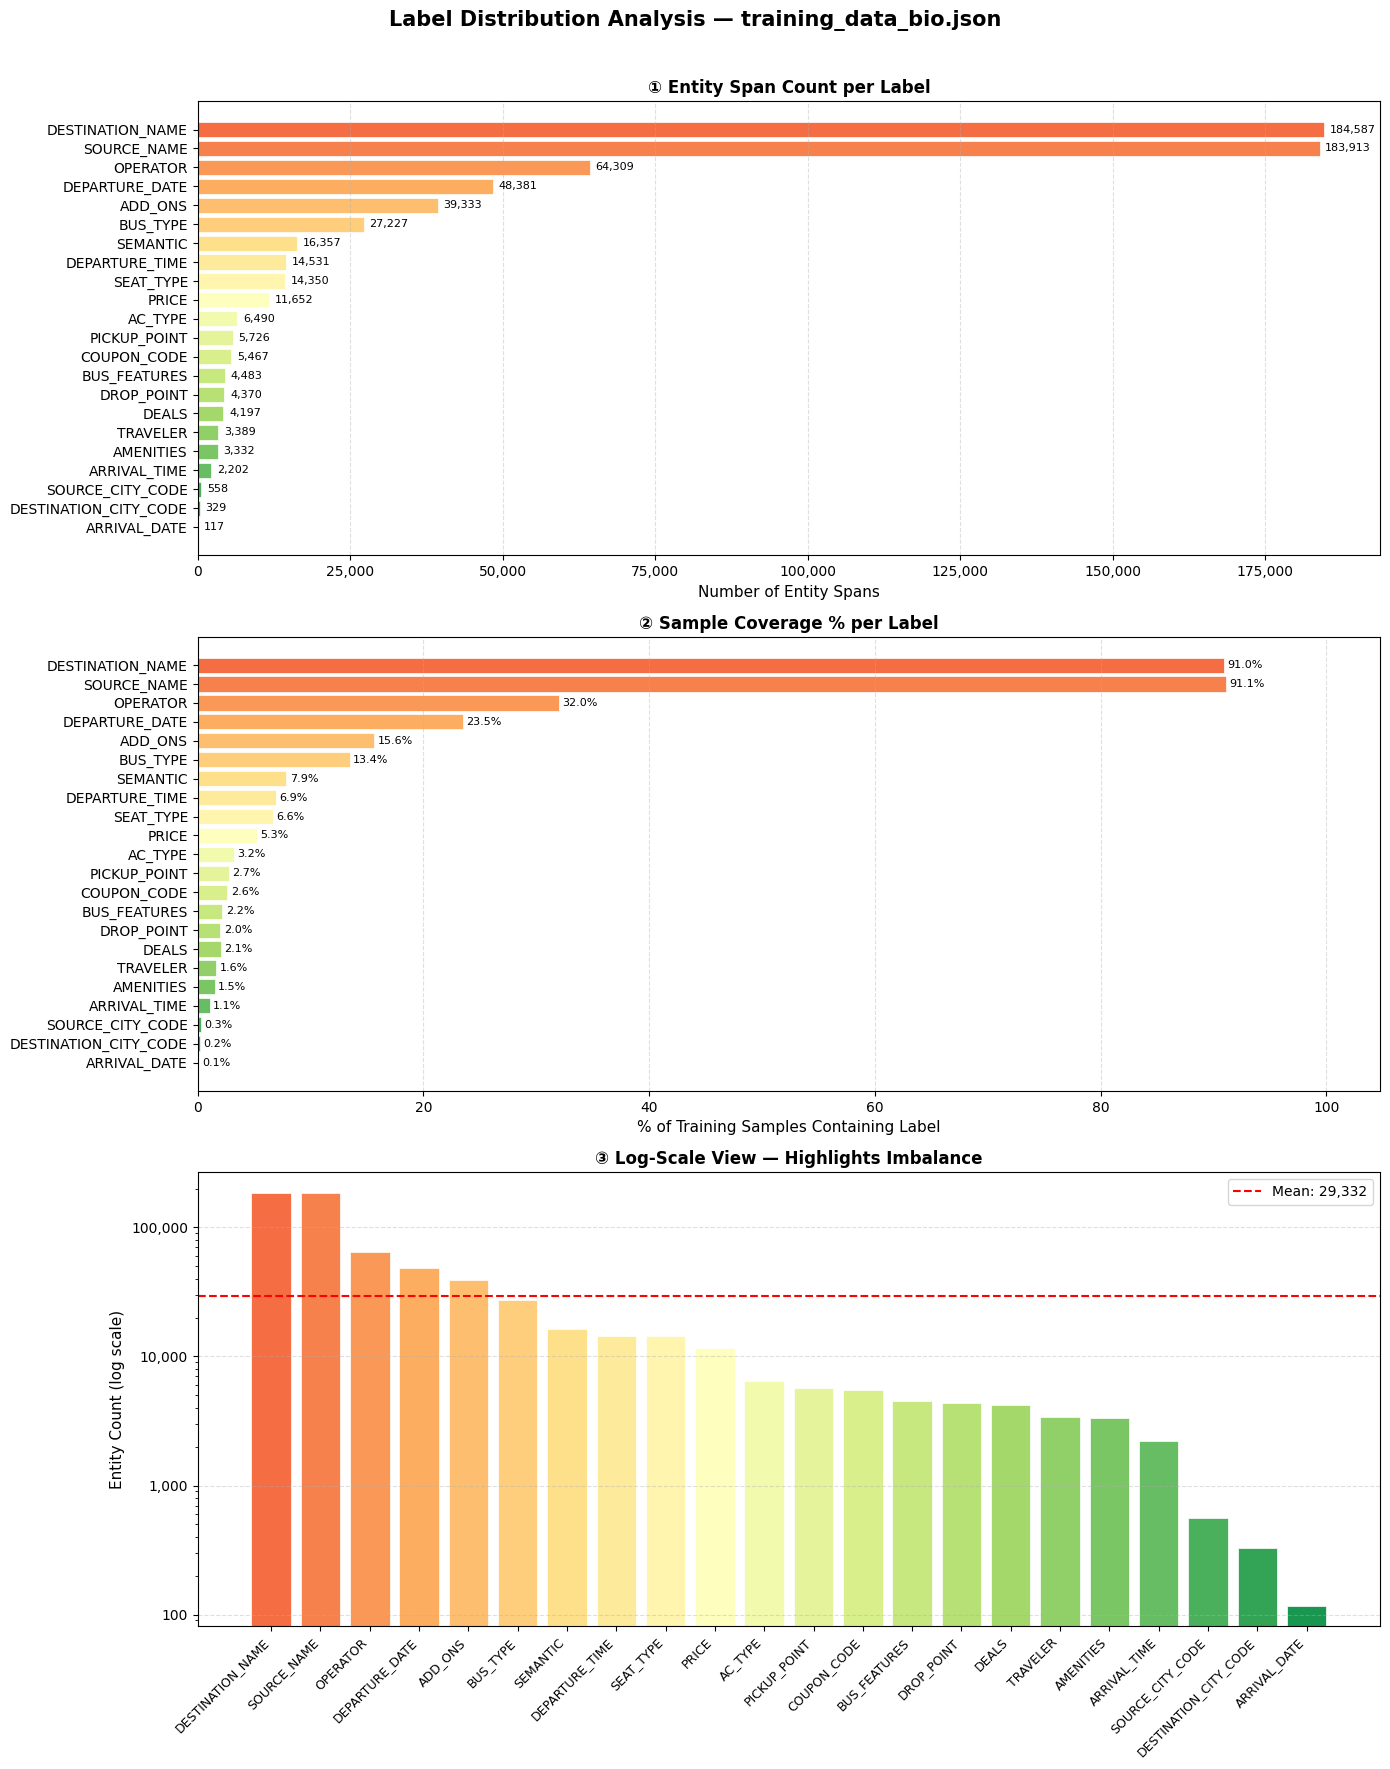

✅ Plot saved to data/label_distribution.png


In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

labels   = df["Label"].tolist()
entities = df["Entities"].tolist()
samples  = df["% Samples"].tolist()
colors   = plt.cm.RdYlGn(np.linspace(0.2, 0.9, len(labels)))

fig, axes = plt.subplots(3, 1, figsize=(14, 18))
fig.suptitle("Label Distribution Analysis — training_data_bio.json", fontsize=15, fontweight="bold", y=0.98)

# ── Plot 1: Entity span count (horizontal bar) ────────────────────────────────
ax1 = axes[0]
bars = ax1.barh(labels, entities, color=colors, edgecolor="white", linewidth=0.5)
ax1.set_xlabel("Number of Entity Spans", fontsize=11)
ax1.set_title("① Entity Span Count per Label", fontsize=12, fontweight="bold")
ax1.invert_yaxis()
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
for bar, val in zip(bars, entities):
    ax1.text(bar.get_width() + max(entities)*0.005, bar.get_y() + bar.get_height()/2,
             f"{val:,}", va="center", fontsize=8)
ax1.grid(axis="x", linestyle="--", alpha=0.4)

# ── Plot 2: % of samples containing each label ────────────────────────────────
ax2 = axes[1]
bars2 = ax2.barh(labels, samples, color=colors, edgecolor="white", linewidth=0.5)
ax2.set_xlabel("% of Training Samples Containing Label", fontsize=11)
ax2.set_title("② Sample Coverage % per Label", fontsize=12, fontweight="bold")
ax2.invert_yaxis()
ax2.set_xlim(0, max(samples) * 1.15)
for bar, val in zip(bars2, samples):
    ax2.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
             f"{val:.1f}%", va="center", fontsize=8)
ax2.grid(axis="x", linestyle="--", alpha=0.4)

# ── Plot 3: Log-scale comparison to highlight imbalance ───────────────────────
ax3 = axes[2]
x = np.arange(len(labels))
bars3 = ax3.bar(x, entities, color=colors, edgecolor="white", linewidth=0.5)
ax3.set_yscale("log")
ax3.set_xticks(x)
ax3.set_xticklabels(labels, rotation=45, ha="right", fontsize=9)
ax3.set_ylabel("Entity Count (log scale)", fontsize=11)
ax3.set_title("③ Log-Scale View — Highlights Imbalance", fontsize=12, fontweight="bold")
ax3.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{int(y):,}"))
ax3.grid(axis="y", linestyle="--", alpha=0.4)
# Draw mean line
mean_val = np.mean(entities)
ax3.axhline(mean_val, color="red", linestyle="--", linewidth=1.5, label=f"Mean: {mean_val:,.0f}")
ax3.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("data/label_distribution.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅ Plot saved to data/label_distribution.png")

In [35]:
import json
from pathlib import Path
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification

# ✅ Use your latest trained model
MODEL_PATH = "models/bus_ner_transformer_v5"

query = "show me bus from delhi to jaipur for tomorow, i prefer ac sleeper with charging points, and clean and punctual bus, i want to board at majnu ka tilla, and drop at hawa mahal"

# Load model + tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH)
model.eval()

# Load label mappings
with open(Path(MODEL_PATH) / "id2label.json", "r") as f:
    id2label = {int(k): v for k, v in json.load(f).items()}

# Tokenize at word level (matches training)
words = query.split()
encoding = tokenizer(
    words,
    is_split_into_words=True,
    return_tensors="pt",
    truncation=True,
    max_length=128,
)

# Predict
with torch.no_grad():
    logits = model(**encoding).logits

pred_ids = logits.argmax(dim=-1)[0].tolist()
word_ids = encoding.word_ids(0)

# Convert to BIO tags per word (use first subword of each word)
bio_tags = []
prev_word_idx = None
for idx, word_idx in enumerate(word_ids):
    if word_idx is None:
        continue
    if word_idx != prev_word_idx:
        bio_tags.append(id2label[pred_ids[idx]])
    prev_word_idx = word_idx

# Print token + tag
print("TOKEN\t\tBIO_TAG")
print("-" * 40)
for w, t in zip(words, bio_tags):
    print(f"{w:<15} {t}")

# JSON-style output
print("\nBIO Output:")
print({"tokens": words, "bio_tags": bio_tags})

TOKEN		BIO_TAG
----------------------------------------
show            O
me              O
bus             O
from            O
delhi           B-SOURCE_NAME
to              O
jaipur          B-DESTINATION_NAME
for             O
tomorow,        B-DESTINATION_NAME
i               O
prefer          O
ac              B-AC_TYPE
sleeper         B-SEAT_TYPE
with            O
charging        B-AMENITIES
points,         I-AMENITIES
and             O
clean           O
and             O
punctual        O
bus,            O
i               O
want            O
to              O
board           O
at              O
majnu           B-PICKUP_POINT
ka              I-PICKUP_POINT
tilla,          I-PICKUP_POINT
and             O
drop            O
at              O
hawa            B-DESTINATION_NAME
mahal           O

BIO Output:
{'tokens': ['show', 'me', 'bus', 'from', 'delhi', 'to', 'jaipur', 'for', 'tomorow,', 'i', 'prefer', 'ac', 'sleeper', 'with', 'charging', 'points,', 'and', 'clean', 'and', 'punctua

In [2]:
!pip install python-dotenv

  Using cached python_dotenv-1.2.1-py3-none-any.whl (21 kB)
You should consider upgrading via the '/Users/int1964/NerModel_GTEXP1.0/venv/bin/python3 -m pip install --upgrade pip' command.


In [5]:
# Reload the module to pick up changes
import importlib
import inference
importlib.reload(inference)
from inference import BusNERInference

# Load model
model_path = "models/bus_ner_deberta_v3_small_4.0"
ner = BusNERInference(model_path, use_onnx=False)

# Test query WITH quotes
query = "Book 'RS Yadav Smart Bus' from Delhi to Goa"

# Get raw predictions
entity_tuples = ner._predict(query)

print("=" * 70)
print("RAW MODEL PREDICTIONS (After Fix)")
print("=" * 70)
print(f"Original Query: {query}")
print(f"Cleaned Query:  {query}")  # Will show without quotes
print(f"\nTokens: {query.split()}")  # After cleaning
print("\nRaw Entities Detected:")
print("-" * 70)

result = {entity_type: [] for entity_type in ner.entity_types}

for entity_text, label, start_char, end_char in entity_tuples:
    print(f"  [{label:20s}] '{entity_text}'")
    if entity_text not in result[label]:
        result[label].append(entity_text)

print("\nOPERATOR:", result['OPERATOR'])  # Should show RS Yadav Smart Bus now! ✅

The tokenizer you are loading from 'models/bus_ner_deberta_v3_small_4.0' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loaded PyTorch model from: models/bus_ner_deberta_v3_small_4.0
Device: cpu
Number of labels: 45
RAW MODEL PREDICTIONS (After Fix)
Original Query: Book 'RS Yadav Smart Bus' from Delhi to Goa
Cleaned Query:  Book 'RS Yadav Smart Bus' from Delhi to Goa

Tokens: ['Book', "'RS", 'Yadav', 'Smart', "Bus'", 'from', 'Delhi', 'to', 'Goa']

Raw Entities Detected:
----------------------------------------------------------------------
  [OPERATOR            ] 'RS Yadav Smart Bus'
  [SOURCE_NAME         ] 'Delhi'
  [DESTINATION_NAME    ] 'Goa'

OPERATOR: ['RS Yadav Smart Bus']


In [13]:
#!/usr/bin/env python3
"""
Evaluate NER model on evaluation_data_bio.json

This script:
1. Loads the BIO-formatted evaluation data
2. Reconstructs text from tokens
3. Runs model inference
4. Converts both ground truth and predictions to entity sets
5. Calculates precision, recall, F1 per entity type and overall
6. Shows detailed failures for each test case
"""

import json
import sys
import os
from pathlib import Path
from typing import Dict, List, Tuple, Set
from collections import defaultdict

# Add project root to path (for Jupyter notebook)
project_root = Path.cwd()  # Use current working directory
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / "src"))

from src.inference import BusNERInference

# =============================================================================
# CONFIGURATION
# =============================================================================

MODEL_PATH = "models/bus_ner_minilm_v7_patched"
EVAL_DATA_PATH = "data/evaluation_data_bio.json"
ENTITY_LABELS = [
    "SOURCE_NAME", "SOURCE_CITY_CODE", "DESTINATION_NAME", "DESTINATION_CITY_CODE",
    "DEPARTURE_DATE", "ARRIVAL_DATE", "DEPARTURE_TIME", "ARRIVAL_TIME",
    "PICKUP_POINT", "DROP_POINT", "AC_TYPE", "BUS_TYPE", "SEAT_TYPE",
    "AMENITIES", "BUS_FEATURES", "OPERATOR", "COUPON_CODE", "DEALS",
    "ADD_ONS", "PRICE", "SEMANTIC", "TRAVELER"
]

# Load label mappings
with open("data/label2id.json") as f:
    label2id = json.load(f)
    id2label = {v: k for k, v in label2id.items()}


# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def bio_to_text(tokens: List[str]) -> str:
    """Reconstruct text from tokens."""
    return " ".join(tokens)


def bio_to_entities(tokens: List[str], ner_tags: List[int]) -> Dict[str, Set[str]]:
    """
    Convert BIO tags to entity sets.
    
    Returns:
        Dict mapping entity type to set of entity values
    """
    entities = defaultdict(set)
    current_entity = []
    current_label = None
    
    for token, tag_id in zip(tokens, ner_tags):
        tag = id2label.get(tag_id, "O")
        
        if tag == "O":
            # End current entity if exists
            if current_entity and current_label:
                entity_text = " ".join(current_entity)
                entities[current_label].add(entity_text)
            current_entity = []
            current_label = None
            
        elif tag.startswith("B-"):
            # Begin new entity (save previous if exists)
            if current_entity and current_label:
                entity_text = " ".join(current_entity)
                entities[current_label].add(entity_text)
            
            current_label = tag[2:]  # Remove "B-"
            current_entity = [token]
            
        elif tag.startswith("I-"):
            # Continue entity
            label = tag[2:]
            if label == current_label:
                current_entity.append(token)
            else:
                # Mismatched I- tag, start new entity
                if current_entity and current_label:
                    entity_text = " ".join(current_entity)
                    entities[current_label].add(entity_text)
                current_label = label
                current_entity = [token]
    
    # Add final entity if exists
    if current_entity and current_label:
        entity_text = " ".join(current_entity)
        entities[current_label].add(entity_text)
    
    return dict(entities)


def prediction_to_entities(pred_dict: Dict[str, List[str]]) -> Dict[str, Set[str]]:
    """Convert model prediction dict to entity sets."""
    return {k: set(v) for k, v in pred_dict.items() if v}


def calculate_metrics(
    true_entities: Dict[str, Set[str]],
    pred_entities: Dict[str, Set[str]]
) -> Tuple[int, int, int]:
    """
    Calculate TP, FP, FN for entity sets.
    
    Returns:
        (true_positives, false_positives, false_negatives)
    """
    tp = 0
    fp = 0
    fn = 0
    
    all_labels = set(list(true_entities.keys()) + list(pred_entities.keys()))
    
    for label in all_labels:
        true_set = true_entities.get(label, set())
        pred_set = pred_entities.get(label, set())
        
        tp += len(true_set & pred_set)  # Intersection
        fp += len(pred_set - true_set)  # Predicted but not true
        fn += len(true_set - pred_set)  # True but not predicted
    
    return tp, fp, fn


def compute_f1(tp: int, fp: int, fn: int) -> Tuple[float, float, float]:
    """Compute precision, recall, F1 from counts."""
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    return precision, recall, f1


def find_failures(true_entities: Dict[str, Set[str]], pred_entities: Dict[str, Set[str]]) -> Dict:
    """Find missing (FN) and incorrect (FP) predictions."""
    failures = {
        "missing": {},  # False Negatives
        "incorrect": {},  # False Positives
        "correct": {}  # True Positives
    }
    
    all_labels = set(list(true_entities.keys()) + list(pred_entities.keys()))
    
    for label in all_labels:
        true_set = true_entities.get(label, set())
        pred_set = pred_entities.get(label, set())
        
        # Missing (should have detected but didn't)
        missing = true_set - pred_set
        if missing:
            failures["missing"][label] = list(missing)
        
        # Incorrect (detected but wrong)
        incorrect = pred_set - true_set
        if incorrect:
            failures["incorrect"][label] = list(incorrect)
        
        # Correct
        correct = true_set & pred_set
        if correct:
            failures["correct"][label] = list(correct)
    
    return failures


# =============================================================================
# MAIN EVALUATION
# =============================================================================

print("=" * 80)
print("NER MODEL EVALUATION")
print("=" * 80)
print(f"Model: {MODEL_PATH}")
print(f"Evaluation Data: {EVAL_DATA_PATH}")
print()

# Load model
print("Loading model...")
model = BusNERInference(MODEL_PATH)
print("✓ Model loaded\n")

# Load evaluation data
print("Loading evaluation data...")
with open(EVAL_DATA_PATH) as f:
    eval_data = json.load(f)
print(f"✓ Loaded {len(eval_data)} samples\n")

# Initialize metrics tracking
overall_tp, overall_fp, overall_fn = 0, 0, 0
per_entity_metrics = {
    label: {"tp": 0, "fp": 0, "fn": 0}
    for label in ENTITY_LABELS
}

# Track detailed failures
test_case_failures = []

# Evaluate each sample
print("Evaluating samples...")
errors = []

for idx, sample in enumerate(eval_data):
    if (idx + 1) % 20 == 0:
        print(f"  Processed {idx + 1}/{len(eval_data)} samples...")
    
    tokens = sample["tokens"]
    true_tags = sample["ner_tags"]
    
    # Reconstruct text
    text = bio_to_text(tokens)
    
    # Get ground truth entities
    true_entities = bio_to_entities(tokens, true_tags)
    
    # Get model predictions
    try:
        pred_dict = model.extract(text)
        pred_entities = prediction_to_entities(pred_dict)
    except Exception as e:
        errors.append({"sample_idx": idx, "text": text, "error": str(e)})
        continue
    
    # Calculate overall metrics
    tp, fp, fn = calculate_metrics(true_entities, pred_entities)
    overall_tp += tp
    overall_fp += fp
    overall_fn += fn
    
    # Calculate per-entity metrics
    for label in ENTITY_LABELS:
        true_set = true_entities.get(label, set())
        pred_set = pred_entities.get(label, set())
        
        per_entity_metrics[label]["tp"] += len(true_set & pred_set)
        per_entity_metrics[label]["fp"] += len(pred_set - true_set)
        per_entity_metrics[label]["fn"] += len(true_set - pred_set)
    
    # Track test case if it has any failures
    if fp > 0 or fn > 0:
        failures = find_failures(true_entities, pred_entities)
        test_case_failures.append({
            "test_id": idx + 1,
            "query": text,
            "failures": failures,
            "tp": tp,
            "fp": fp,
            "fn": fn
        })

print(f"✓ Evaluation complete!\n")

if errors:
    print(f"⚠ Warning: {len(errors)} samples had errors\n")

# Calculate and display overall metrics
print("=" * 80)
print("OVERALL METRICS")
print("=" * 80)

precision, recall, f1 = compute_f1(overall_tp, overall_fp, overall_fn)

print(f"True Positives:  {overall_tp}")
print(f"False Positives: {overall_fp}")
print(f"False Negatives: {overall_fn}")
print()
print(f"Precision: {precision:.4f} ({precision * 100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall * 100:.2f}%)")
print(f"F1 Score:  {f1:.4f} ({f1 * 100:.2f}%)")
print()

# Calculate and display per-entity metrics
print("=" * 80)
print("PER-ENTITY METRICS")
print("=" * 80)
print(f"{'Entity':<25} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Support':<10}")
print("-" * 80)

entity_results = []
for label in ENTITY_LABELS:
    metrics = per_entity_metrics[label]
    tp = metrics["tp"]
    fp = metrics["fp"]
    fn = metrics["fn"]
    support = tp + fn
    
    if support == 0:
        continue
    
    prec, rec, f1_score = compute_f1(tp, fp, fn)
    entity_results.append((label, prec, rec, f1_score, support))

# Sort by F1 score (ascending to show worst first)
entity_results.sort(key=lambda x: x[3])

for label, prec, rec, f1_score, support in entity_results:
    print(f"{label:<25} {prec:<12.4f} {rec:<12.4f} {f1_score:<12.4f} {support:<10}")

print()

# Show worst performing entities
print("=" * 80)
print("TOP 5 WORST PERFORMING ENTITIES (by F1)")
print("=" * 80)
worst_5 = entity_results[:5] if len(entity_results) >= 5 else entity_results
for label, prec, rec, f1_score, support in worst_5:
    print(f"{label:<25} F1: {f1_score:.4f}  (P: {prec:.4f}, R: {rec:.4f}, Support: {support})")
print()

# Show best performing entities
print("=" * 80)
print("TOP 5 BEST PERFORMING ENTITIES (by F1)")
print("=" * 80)
best_5 = entity_results[-5:][::-1] if len(entity_results) >= 5 else entity_results[::-1]
for label, prec, rec, f1_score, support in best_5:
    print(f"{label:<25} F1: {f1_score:.4f}  (P: {prec:.4f}, R: {rec:.4f}, Support: {support})")
print()

# Show detailed failures for each test case
print("=" * 80)
print(f"DETAILED TEST CASE FAILURES ({len(test_case_failures)} failures)")
print("=" * 80)

if test_case_failures:
    # Show first 10 failing test cases
    for i, failure in enumerate(test_case_failures[:10]):
        print(f"\n[Test #{failure['test_id']}] FAILED (FP: {failure['fp']}, FN: {failure['fn']})")
        print(f"Query: {failure['query'][:80]}{'...' if len(failure['query']) > 80 else ''}")
        
        # Show missing entities (False Negatives)
        if failure['failures']['missing']:
            print("  ❌ MISSING (should detect but didn't):")
            for label, entities in failure['failures']['missing'].items():
                for entity in entities:
                    print(f"      {label}: '{entity}'")
        
        # Show incorrect entities (False Positives)
        if failure['failures']['incorrect']:
            print("  ⚠️  INCORRECT (detected but wrong):")
            for label, entities in failure['failures']['incorrect'].items():
                for entity in entities:
                    print(f"      {label}: '{entity}'")
        
        # Show correct entities (for context)
        if failure['failures']['correct']:
            print("  ✅ CORRECT:")
            for label, entities in failure['failures']['correct'].items():
                print(f"      {label}: {', '.join(entities)}")
    
    if len(test_case_failures) > 10:
        print(f"\n... and {len(test_case_failures) - 10} more failing test cases")
else:
    print("\n🎉 NO FAILURES! All test cases passed perfectly!")

print()

# Save detailed results
results = {
    "model_path": MODEL_PATH,
    "eval_data_path": EVAL_DATA_PATH,
    "num_samples": len(eval_data),
    "num_failures": len(test_case_failures),
    "overall": {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "tp": overall_tp,
        "fp": overall_fp,
        "fn": overall_fn
    },
    "per_entity": {
        label: {
            "precision": prec,
            "recall": rec,
            "f1": f1_score,
            "support": support,
            "tp": per_entity_metrics[label]["tp"],
            "fp": per_entity_metrics[label]["fp"],
            "fn": per_entity_metrics[label]["fn"]
        }
        for label, prec, rec, f1_score, support in entity_results
    },
    "test_case_failures": test_case_failures,  # Include all failures
    "errors": errors[:10]  # Save first 10 errors
}

output_file = "evaluation_results.json"
with open(output_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"✓ Detailed results saved to: {output_file}")
print(f"  (includes all {len(test_case_failures)} failing test cases)")
print("=" * 80)

NER MODEL EVALUATION
Model: models/bus_ner_minilm_v7_patched
Evaluation Data: data/evaluation_data_bio.json

Loading model...
Loaded PyTorch model from: models/bus_ner_minilm_v7_patched
Device: cpu
Number of labels: 45
✓ Model loaded

Loading evaluation data...
✓ Loaded 100 samples

Evaluating samples...
  Processed 20/100 samples...
  Processed 40/100 samples...
  Processed 60/100 samples...
  Processed 80/100 samples...
  Processed 100/100 samples...
✓ Evaluation complete!

OVERALL METRICS
True Positives:  191
False Positives: 133
False Negatives: 90

Precision: 0.5895 (58.95%)
Recall:    0.6797 (67.97%)
F1 Score:  0.6314 (63.14%)

PER-ENTITY METRICS
Entity                    Precision    Recall       F1           Support   
--------------------------------------------------------------------------------
DESTINATION_NAME          0.5055       0.5055       0.5055       91        
OPERATOR                  0.5732       0.5875       0.5802       80        
SEMANTIC                  0.57

In [10]:
import json
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd()))
sys.path.insert(0, str(Path.cwd() / "src"))

from src.data_generator import convert_span_to_bio

# File paths
SPAN_INPUT = "data/evaluation_data_span.json"
BIO_OUTPUT = "data/evaluation_data_bio.json"

print("=" * 80)
print("CONVERTING EVALUATION DATA: SPAN → BIO")
print("=" * 80)

# Load span data
print(f"\n📂 Loading: {SPAN_INPUT}")
with open(SPAN_INPUT, 'r') as f:
    span_data = json.load(f)
print(f"✓ Loaded {len(span_data)} samples")

# Show sample
print("\n📋 Sample input:")
if span_data:
    sample = span_data[0]
    print(f"   Text: {sample['text'][:60]}...")
    print(f"   Entities: {len(sample['entities'])} entities")
    for start, end, label in sample['entities']:
        entity_text = sample['text'][start:end]
        print(f"      [{start}:{end}] {label}: '{entity_text}'")

# Convert to BIO
print("\n🔄 Converting to BIO format...")
bio_data = []
skipped = 0
errors = []

for idx, sample in enumerate(span_data):
    try:
        bio_sample = convert_span_to_bio(sample)
        
        if bio_sample:
            bio_data.append(bio_sample)
        else:
            skipped += 1
            errors.append({
                "index": idx,
                "text": sample.get('text', '')[:50],
                "reason": "Conversion returned None"
            })
    except Exception as e:
        skipped += 1
        errors.append({
            "index": idx,
            "text": sample.get('text', '')[:50],
            "reason": str(e)
        })

print(f"✓ Successfully converted: {len(bio_data)} samples")

if skipped > 0:
    print(f"⚠️  Skipped: {skipped} samples")
    print("\nErrors:")
    for error in errors:
        print(f"  [{error['index']}] {error['text']}... - {error['reason']}")

# Show sample output with aligned format
if bio_data:
    print("\n📋 Sample output (aligned format):")
    sample_bio = bio_data[0]
    tokens_str = " | ".join(sample_bio['tokens'][:8])
    tags_str = " | ".join([str(tag).center(len(token)) for token, tag in zip(sample_bio['tokens'][:8], sample_bio['ner_tags'][:8])])
    print(f"   Tokens: {tokens_str} ...")
    print(f"   Tags:   {tags_str} ...")

# Save BIO data in ALIGNED format (tag directly below each token)
print(f"\n💾 Saving to: {BIO_OUTPUT} (aligned format)")
with open(BIO_OUTPUT, 'w') as f:
    f.write('[\n')
    for i, sample in enumerate(bio_data):
        tokens = sample["tokens"]
        ner_tags = sample["ner_tags"]
        
        f.write('  {\n')
        
        # Write tokens line
        f.write('    "tokens":   [')
        token_parts = [f'"{token}"' for token in tokens]
        f.write(', '.join(token_parts))
        f.write('],\n')
        
        # Write ner_tags line (aligned below tokens)
        f.write('    "ner_tags": [')
        tag_parts = []
        for j, (token, tag) in enumerate(zip(tokens, ner_tags)):
            # Calculate spacing to align with token above
            token_str = f'"{token}"'
            tag_str = str(tag)
            # Pad tag to match token width
            padding = len(token_str) - len(tag_str)
            if padding > 0:
                tag_parts.append(' ' * (padding // 2) + tag_str + ' ' * ((padding + 1) // 2))
            else:
                tag_parts.append(tag_str)
        f.write(', '.join(tag_parts))
        f.write(']\n')
        
        if i < len(bio_data) - 1:
            f.write('  },\n')
        else:
            f.write('  }\n')
    f.write(']\n')

print(f"✓ Saved {len(bio_data)} samples in aligned format")

print("\n" + "=" * 80)
print("✅ CONVERSION COMPLETE!")
print("=" * 80)
print(f"\nYour {len(bio_data)} samples are ready for evaluation!")
print("\nFormat preview:")
print('  "tokens":   ["Please", "confirm", "your", ...]')
print('  "ner_tags": [   0    ,    0    ,   0  , ...]')
print("\nEach NER tag is vertically aligned with its corresponding token!")

CONVERTING EVALUATION DATA: SPAN → BIO

📂 Loading: data/evaluation_data_span.json
✓ Loaded 5 samples

📋 Sample input:
   Text: Please confirm your booking for a bus from Shivamogga to Kod...
   Entities: 5 entities
      [43:53] SOURCE_NAME: 'Shivamogga'
      [57:67] DESTINATION_NAME: 'Kodachadri'
      [71:81] DEPARTURE_DATE: '03-10-2025'
      [85:93] DEPARTURE_TIME: '05:00 pm'
      [98:109] TRAVELER: '1 traveler.'

🔄 Converting to BIO format...
✓ Successfully converted: 5 samples

📋 Sample output (aligned format):
   Tokens: Please | confirm | your | booking | for | a | bus | from ...
   Tags:     0    |    0    |  0   |    0    |  0  | 0 |  0  |  0   ...

💾 Saving to: data/evaluation_data_bio.json (aligned format)
✓ Saved 5 samples in aligned format

✅ CONVERSION COMPLETE!

Your 5 samples are ready for evaluation!

Format preview:
  "tokens":   ["Please", "confirm", "your", ...]
  "ner_tags": [   0    ,    0    ,   0  , ...]

Each NER tag is vertically aligned with its correspond

In [14]:
#!/usr/bin/env python3
"""
Validate and auto-fix spans in evaluation_data_span.json
to align with regex tokenizer boundaries.
"""

import json
import re
from pathlib import Path

# Same regex as in data_generator.py
TOKEN_REGEX = r"₹\d+(?:,\d+)*(?:\.\d+)?|\d{1,2}:\d{2}|[A-Za-z0-9_]+(?:[-/][A-Za-z0-9_]+)*|[^\w\s]"

def get_token_spans(text):
    """Get all token spans from text using the same regex as data_generator."""
    token_matches = list(re.finditer(TOKEN_REGEX, text))
    return [(m.start(), m.end(), m.group(0)) for m in token_matches]

def find_best_token_alignment(text, entity_start, entity_end, entity_label):
    """
    Find tokens that best match the entity span.
    Returns corrected (start, end) positions that align with token boundaries.
    """
    tokens = get_token_spans(text)
    
    # Find all tokens that overlap with the entity span
    overlapping_tokens = []
    for token_start, token_end, token_text in tokens:
        # Token overlaps if it starts before entity ends AND ends after entity starts
        if token_start < entity_end and token_end > entity_start:
            overlapping_tokens.append((token_start, token_end, token_text))
    
    if not overlapping_tokens:
        print(f"  ⚠️  WARNING: No tokens found for entity '{text[entity_start:entity_end]}' ({entity_label})")
        return entity_start, entity_end, False
    
    # The corrected span should be from the first token start to the last token end
    corrected_start = overlapping_tokens[0][0]
    corrected_end = overlapping_tokens[-1][1]
    
    # Check if correction was needed
    needs_fix = (corrected_start != entity_start or corrected_end != entity_end)
    
    if needs_fix:
        original_text = text[entity_start:entity_end]
        corrected_text = text[corrected_start:corrected_end]
        print(f"  🔧 FIXED {entity_label}:")
        print(f"     Original [{entity_start}:{entity_end}]: '{original_text}'")
        print(f"     Corrected [{corrected_start}:{corrected_end}]: '{corrected_text}'")
    
    return corrected_start, corrected_end, needs_fix

def fix_evaluation_data(input_file, output_file):
    """Fix all spans in evaluation data."""
    print("=" * 80)
    print("FIXING EVALUATION DATA SPANS")
    print("=" * 80)
    
    # Load data
    print(f"\n📂 Loading: {input_file}")
    with open(input_file, 'r') as f:
        data = json.load(f)
    print(f"✓ Loaded {len(data)} samples")
    
    # Fix each sample
    fixed_count = 0
    total_entities = 0
    
    for idx, sample in enumerate(data):
        text = sample['text']
        entities = sample['entities']
        
        if not entities:
            continue
        
        sample_fixed = False
        fixed_entities = []
        
        for entity in entities:
            start, end, label = entity
            total_entities += 1
            
            # Get corrected span
            new_start, new_end, needs_fix = find_best_token_alignment(text, start, end, label)
            
            if needs_fix:
                if not sample_fixed:
                    print(f"\n[Sample #{idx + 1}]")
                    print(f"Text: {text[:80]}{'...' if len(text) > 80 else ''}")
                sample_fixed = True
            
            fixed_entities.append([new_start, new_end, label])
        
        if sample_fixed:
            fixed_count += 1
        
        # Update sample with fixed entities
        sample['entities'] = fixed_entities
    
    # Save fixed data
    print(f"\n💾 Saving to: {output_file}")
    with open(output_file, 'w') as f:
        json.dump(data, f, indent=2)
    
    print("\n" + "=" * 80)
    print("SUMMARY")
    print("=" * 80)
    print(f"Total samples: {len(data)}")
    print(f"Total entities: {total_entities}")
    print(f"Samples with fixes: {fixed_count}")
    print(f"✅ Fixed data saved to: {output_file}")
    print("=" * 80)

if __name__ == "__main__":
    input_file = "data/evaluation_data_span.json"
    output_file = "data/evaluation_data_span_fixed.json"
    
    fix_evaluation_data(input_file, output_file)
    
    print("\n📝 Next steps:")
    print("1. Review the fixed file: data/evaluation_data_span_fixed.json")
    print("2. If looks good, replace original:")
    print("   mv data/evaluation_data_span_fixed.json data/evaluation_data_span.json")
    print("3. Re-run conversion: python convert_eval_span_to_bio.py")
    print("4. Re-run evaluation: jupyter notebook evaluate_model.ipynb")

FIXING EVALUATION DATA SPANS

📂 Loading: data/evaluation_data_span.json
✓ Loaded 100 samples
  🔧 FIXED OPERATOR:
     Original [60:92]: 'l travels and logistics bus from'
     Corrected [53:92]: 'National travels and logistics bus from'

[Sample #1]
Text: What is the cancellation policy for the Journey with National travels and logist...
  🔧 FIXED SOURCE_NAME:
     Original [98:107]: 'lore to P'
     Corrected [93:114]: 'Bangalore to Payyanur'
  🔧 FIXED DESTINATION_NAME:
     Original [111:119]: 'nur?'
     Corrected [106:115]: 'Payyanur?'
  🔧 FIXED OPERATOR:
     Original [53:70]: 'Maharani Travels '
     Corrected [53:69]: 'Maharani Travels'

[Sample #8]
Text: What is the cancellation policy for the Journey with Maharani Travels Bus from D...
  🔧 FIXED SOURCE_NAME:
     Original [80:85]: 'elhi '
     Corrected [79:84]: 'Delhi'
  🔧 FIXED DESTINATION_NAME:
     Original [89:95]: 'aipur?'
     Corrected [88:95]: 'Jaipur?'
  🔧 FIXED OPERATOR:
     Original [68:95]: 'aj Kalpana Travels Pv

In [15]:
import requests
import json
from collections import defaultdict

API_URL = "http://localhost:8100/ner/extract"

In [37]:
TEST_CASES = [
    # 1
    {"query": "hey can you help me find a bus from bangalore to goa for this weekend i want something comfortable",
     "expected": {"SOURCE_NAME": ["bangalore"], "DESTINATION_NAME": ["goa"], "DEPARTURE_DATE": ["this weekend"], "SEMANTIC": ["comfortable"]}},
    # 2
    {"query": "i am planning to travel from mumbai to pune tomorrow morning so please show me some good ac buses",
     "expected": {"SOURCE_NAME": ["mumbai"], "DESTINATION_NAME": ["pune"], "DEPARTURE_DATE": ["tomorrow"], "DEPARTURE_TIME": ["morning"], "AC_TYPE": ["ac"]}},
    # 3
    {"query": "we are a group of 4 passengers and we want to book sleeper tickets from chennai to bangalore on friday night",
     "expected": {"TRAVELER": ["4 passengers"], "SEAT_TYPE": ["sleeper"], "SOURCE_NAME": ["chennai"], "DESTINATION_NAME": ["bangalore"], "DEPARTURE_DATE": ["friday"], "DEPARTURE_TIME": ["night"]}},
    # 4
    {"query": "can you please find me the cheapest overnight bus from delhi to jaipur because i want to save some money",
     "expected": {"SEMANTIC": ["cheapest"], "DEPARTURE_TIME": ["overnight"], "SOURCE_NAME": ["delhi"], "DESTINATION_NAME": ["jaipur"]}},
    # 5
    {"query": "i want to book 2 tickets on a VRL ac sleeper bus from hyderabad to bangalore on 15th march at night",
     "expected": {"TRAVELER": ["2 tickets"], "OPERATOR": ["VRL"], "AC_TYPE": ["ac"], "SEAT_TYPE": ["sleeper"], "SOURCE_NAME": ["hyderabad"], "DESTINATION_NAME": ["bangalore"], "DEPARTURE_DATE": ["15th march"], "DEPARTURE_TIME": ["night"]}},
    # 6
    {"query": "please show me all available Orange Travels ac buses from hyderabad to bangalore for this saturday evening",
     "expected": {"OPERATOR": ["Orange Travels"], "AC_TYPE": ["ac"], "SOURCE_NAME": ["hyderabad"], "DESTINATION_NAME": ["bangalore"], "DEPARTURE_DATE": ["saturday"], "DEPARTURE_TIME": ["evening"]}},
    # 7
    {"query": "my family of 4 wants to travel from pune to goa on 25th december so please find us a reliable ac bus",
     "expected": {"TRAVELER": ["family of 4"], "SOURCE_NAME": ["pune"], "DESTINATION_NAME": ["goa"], "DEPARTURE_DATE": ["25th december"], "SEMANTIC": ["reliable"], "AC_TYPE": ["ac"]}},
    # 8
    {"query": "hey i need a direct bus from mumbai to ahmedabad on sunday that is affordable and has wifi onboard",
     "expected": {"SEMANTIC": ["direct"], "SOURCE_NAME": ["mumbai"], "DESTINATION_NAME": ["ahmedabad"], "DEPARTURE_DATE": ["sunday"], "AMENITIES": ["wifi"]}},
    # 9
    {"query": "looking for a comfortable volvo bus from bangalore to chennai on 20th april with charging point and blanket",
     "expected": {"SEMANTIC": ["comfortable"], "BUS_TYPE": ["volvo"], "SOURCE_NAME": ["bangalore"], "DESTINATION_NAME": ["chennai"], "DEPARTURE_DATE": ["20th april"], "AMENITIES": ["charging point", "blanket"]}},
    # 10
    {"query": "can you show me KSRTC non ac buses from bangalore to mysore for tomorrow morning i prefer seater seats",
     "expected": {"OPERATOR": ["KSRTC"], "AC_TYPE": ["non ac"], "SOURCE_NAME": ["bangalore"], "DESTINATION_NAME": ["mysore"], "DEPARTURE_DATE": ["tomorrow"], "DEPARTURE_TIME": ["morning"], "SEAT_TYPE": ["seater"]}},
    # 11
    {"query": "i want to travel from goa to mumbai on 16th november and i need to come back on 19th november round trip please",
     "expected": {"SOURCE_NAME": ["goa"], "DESTINATION_NAME": ["mumbai"], "DEPARTURE_DATE": ["16th november"], "ARRIVAL_DATE": ["19th november"]}},
    # 12
    {"query": "please help me find a bus from mumbai to pune with pickup at Dadar and drop at Swargate for tomorrow evening",
     "expected": {"SOURCE_NAME": ["mumbai"], "DESTINATION_NAME": ["pune"], "PICKUP_POINT": ["Dadar"], "DROP_POINT": ["Swargate"], "DEPARTURE_DATE": ["tomorrow"], "DEPARTURE_TIME": ["evening"]}},
    # 13
    {"query": "i want to apply the coupon code BUS250 on my booking from delhi to chandigarh on friday morning please",
     "expected": {"COUPON_CODE": ["BUS250"], "SOURCE_NAME": ["delhi"], "DESTINATION_NAME": ["chandigarh"], "DEPARTURE_DATE": ["friday"], "DEPARTURE_TIME": ["morning"]}},
    # 14
    {"query": "show me all the buses from bangalore to chennai that arrive by 6 am tomorrow morning i need to reach early",
     "expected": {"SOURCE_NAME": ["bangalore"], "DESTINATION_NAME": ["chennai"], "ARRIVAL_TIME": ["6 am"], "DEPARTURE_DATE": ["tomorrow"]}},
    # 15
    {"query": "can i get a safe bus from delhi to agra at night for 3 females we want something reliable and comfortable",
     "expected": {"SEMANTIC": ["safe"], "SOURCE_NAME": ["delhi"], "DESTINATION_NAME": ["agra"], "DEPARTURE_TIME": ["night"], "TRAVELER": ["3 females"]}},
    # 16
    {"query": "hey i want a bus from jaipur to udaipur under 500 rupees on thursday because my budget is really tight",
     "expected": {"SOURCE_NAME": ["jaipur"], "DESTINATION_NAME": ["udaipur"], "PRICE": ["under 500"], "DEPARTURE_DATE": ["thursday"]}},
    # 17
    {"query": "please find me a comfortable ac sleeper bus from bangalore to goa on 20th march that departs at night",
     "expected": {"SEMANTIC": ["comfortable"], "AC_TYPE": ["ac"], "SEAT_TYPE": ["sleeper"], "SOURCE_NAME": ["bangalore"], "DESTINATION_NAME": ["goa"], "DEPARTURE_DATE": ["20th march"], "DEPARTURE_TIME": ["night"]}},
    # 18
    {"query": "i need to book 3 tickets on SRS Travels from bangalore to mumbai on saturday night in sleeper class",
     "expected": {"TRAVELER": ["3 tickets"], "OPERATOR": ["SRS Travels"], "SOURCE_NAME": ["bangalore"], "DESTINATION_NAME": ["mumbai"], "DEPARTURE_DATE": ["saturday"], "DEPARTURE_TIME": ["night"], "SEAT_TYPE": ["sleeper"]}},
    # 19
    {"query": "can you help me find a bus from chennai to pondicherry for sunday with travel insurance included in the booking",
     "expected": {"SOURCE_NAME": ["chennai"], "DESTINATION_NAME": ["pondicherry"], "DEPARTURE_DATE": ["sunday"], "ADD_ONS": ["travel insurance"]}},
    # 20
    {"query": "i want to travel from hyderabad to tirupati on 12th april evening and i prefer the fastest bus available",
     "expected": {"SOURCE_NAME": ["hyderabad"], "DESTINATION_NAME": ["tirupati"], "DEPARTURE_DATE": ["12th april"], "DEPARTURE_TIME": ["evening"], "SEMANTIC": ["fastest"]}},
    # 21
    {"query": "show me the best rated ac volvo buses from mumbai to goa on friday night for 2 passengers with wifi",
     "expected": {"SEMANTIC": ["best rated"], "AC_TYPE": ["ac"], "BUS_TYPE": ["volvo"], "SOURCE_NAME": ["mumbai"], "DESTINATION_NAME": ["goa"], "DEPARTURE_DATE": ["friday"], "DEPARTURE_TIME": ["night"], "TRAVELER": ["2 passengers"], "AMENITIES": ["wifi"]}},
    # 22
    {"query": "hey please find an affordable non ac bus from kolkata to siliguri for tomorrow i need to reach before noon",
     "expected": {"SEMANTIC": ["affordable"], "AC_TYPE": ["non ac"], "SOURCE_NAME": ["kolkata"], "DESTINATION_NAME": ["siliguri"], "DEPARTURE_DATE": ["tomorrow"], "ARRIVAL_TIME": ["before noon"]}},
    # 23
    {"query": "i want to go from delhi to manali on 15th june and return on 20th june please show me some overnight options",
     "expected": {"SOURCE_NAME": ["delhi"], "DESTINATION_NAME": ["manali"], "DEPARTURE_DATE": ["15th june"], "ARRIVAL_DATE": ["20th june"], "DEPARTURE_TIME": ["overnight"]}},
    # 24
    {"query": "can i book a Zingbus from delhi to jaipur tomorrow at 9 PM i want a comfortable ac bus for this trip",
     "expected": {"OPERATOR": ["Zingbus"], "SOURCE_NAME": ["delhi"], "DESTINATION_NAME": ["jaipur"], "DEPARTURE_DATE": ["tomorrow"], "DEPARTURE_TIME": ["9 PM"], "SEMANTIC": ["comfortable"], "AC_TYPE": ["ac"]}},
    # 25
    {"query": "looking for buses from BLR to MAA on wednesday morning please show me all the ac options available",
     "expected": {"SOURCE_CITY_CODE": ["BLR"], "DESTINATION_CITY_CODE": ["MAA"], "DEPARTURE_DATE": ["wednesday"], "DEPARTURE_TIME": ["morning"], "AC_TYPE": ["ac"]}},
    # 26
    {"query": "i want a PRIMO bus from hyderabad to bangalore on friday can you also check if there is any deal available",
     "expected": {"BUS_FEATURES": ["PRIMO"], "SOURCE_NAME": ["hyderabad"], "DESTINATION_NAME": ["bangalore"], "DEPARTURE_DATE": ["friday"]}},
    # 27
    {"query": "book me a bus from bangalore to chennai with pickup at Electronic City and drop at Koyambedu on saturday",
     "expected": {"SOURCE_NAME": ["bangalore"], "DESTINATION_NAME": ["chennai"], "PICKUP_POINT": ["Electronic City"], "DROP_POINT": ["Koyambedu"], "DEPARTURE_DATE": ["saturday"]}},
    # 28
    {"query": "please use the coupon FIRSTBUS on my KSRTC booking from bangalore to mangalore on thursday morning at 6 am",
     "expected": {"COUPON_CODE": ["FIRSTBUS"], "OPERATOR": ["KSRTC"], "SOURCE_NAME": ["bangalore"], "DESTINATION_NAME": ["mangalore"], "DEPARTURE_DATE": ["thursday"], "DEPARTURE_TIME": ["6 am"]}},
    # 29
    {"query": "hey i need an ac sleeper bus from pune to goa on 08-12-2025 and it should have a toilet onboard please",
     "expected": {"AC_TYPE": ["ac"], "SEAT_TYPE": ["sleeper"], "SOURCE_NAME": ["pune"], "DESTINATION_NAME": ["goa"], "DEPARTURE_DATE": ["08-12-2025"], "AMENITIES": ["toilet"]}},
    # 30
    {"query": "show me all the non ac seater buses from hyderabad to warangal on friday below ₹500 i dont want expensive ones",
     "expected": {"AC_TYPE": ["non ac"], "SEAT_TYPE": ["seater"], "SOURCE_NAME": ["hyderabad"], "DESTINATION_NAME": ["warangal"], "DEPARTURE_DATE": ["friday"], "PRICE": ["below ₹500"]}},
    # 31
    {"query": "can you find me a KPN ac sleeper from chennai to bangalore tomorrow morning i need to reach there early",
     "expected": {"OPERATOR": ["KPN"], "AC_TYPE": ["ac"], "SEAT_TYPE": ["sleeper"], "SOURCE_NAME": ["chennai"], "DESTINATION_NAME": ["bangalore"], "DEPARTURE_DATE": ["tomorrow"], "DEPARTURE_TIME": ["morning"]}},
    # 32
    {"query": "i am looking for a clean and comfortable bus from bangalore to mysore with water bottle for today afternoon",
     "expected": {"SEMANTIC": ["comfortable"], "SOURCE_NAME": ["bangalore"], "DESTINATION_NAME": ["mysore"], "AMENITIES": ["water bottle"], "DEPARTURE_DATE": ["today"]}},
    # 33
    {"query": "hey please show me IntrCity SmartBus from nagpur to pune on sunday evening for 2 adults in sleeper class",
     "expected": {"OPERATOR": ["IntrCity"], "BUS_TYPE": ["SmartBus"], "SOURCE_NAME": ["nagpur"], "DESTINATION_NAME": ["pune"], "DEPARTURE_DATE": ["sunday"], "DEPARTURE_TIME": ["evening"], "TRAVELER": ["2 adults"], "SEAT_TYPE": ["sleeper"]}},
    # 34
    {"query": "i want to book a bus from mumbai to nashik on sunday with usb charging and i need free cancellation also",
     "expected": {"SOURCE_NAME": ["mumbai"], "DESTINATION_NAME": ["nashik"], "DEPARTURE_DATE": ["sunday"], "AMENITIES": ["usb charging"], "ADD_ONS": ["free cancellation"]}},
    # 35
    {"query": "can you find me 5 tickets on an ac bus from chennai to madurai on thursday morning i want a direct one",
     "expected": {"TRAVELER": ["5 tickets"], "AC_TYPE": ["ac"], "SOURCE_NAME": ["chennai"], "DESTINATION_NAME": ["madurai"], "DEPARTURE_DATE": ["thursday"], "DEPARTURE_TIME": ["morning"], "SEMANTIC": ["direct"]}},
    # 36
    {"query": "please show me reliable GSRTC ac buses from ahmedabad to rajkot for tomorrow night i want wifi onboard",
     "expected": {"SEMANTIC": ["reliable"], "OPERATOR": ["GSRTC"], "AC_TYPE": ["ac"], "SOURCE_NAME": ["ahmedabad"], "DESTINATION_NAME": ["rajkot"], "DEPARTURE_DATE": ["tomorrow"], "DEPARTURE_TIME": ["night"], "AMENITIES": ["wifi"]}},
    # 37
    {"query": "hey i want to book a comfortable volvo ac sleeper from pune to goa for 3 tickets on friday evening please",
     "expected": {"SEMANTIC": ["comfortable"], "BUS_TYPE": ["volvo"], "AC_TYPE": ["ac"], "SEAT_TYPE": ["sleeper"], "SOURCE_NAME": ["pune"], "DESTINATION_NAME": ["goa"], "TRAVELER": ["3 tickets"], "DEPARTURE_DATE": ["friday"], "DEPARTURE_TIME": ["evening"]}},
    # 38
    {"query": "is there a WEEKEND_SPECIAL deal available on any bus from pune to mumbai on this weekend for 2 passengers",
     "expected": {"DEALS": ["WEEKEND_SPECIAL"], "SOURCE_NAME": ["pune"], "DESTINATION_NAME": ["mumbai"], "DEPARTURE_DATE": ["this weekend"], "TRAVELER": ["2 passengers"]}},
    # 39
    {"query": "i need to find the cheapest sleeper bus from delhi to lucknow on friday night because my budget is limited",
     "expected": {"SEMANTIC": ["cheapest"], "SEAT_TYPE": ["sleeper"], "SOURCE_NAME": ["delhi"], "DESTINATION_NAME": ["lucknow"], "DEPARTURE_DATE": ["friday"], "DEPARTURE_TIME": ["night"]}},
    # 40
    {"query": "please book an APSRTC bus from vijayawada to hyderabad for saturday morning i want something under 500",
     "expected": {"OPERATOR": ["APSRTC"], "SOURCE_NAME": ["vijayawada"], "DESTINATION_NAME": ["hyderabad"], "DEPARTURE_DATE": ["saturday"], "DEPARTURE_TIME": ["morning"], "PRICE": ["under 500"]}},
    # 41
    {"query": "can you help me find a bus from indore to bhopal today at 3 pm with ac and semi sleeper seats available",
     "expected": {"SOURCE_NAME": ["indore"], "DESTINATION_NAME": ["bhopal"], "DEPARTURE_DATE": ["today"], "DEPARTURE_TIME": ["3 pm"], "AC_TYPE": ["ac"], "SEAT_TYPE": ["semi sleeper"]}},
    # 42
    {"query": "i am travelling with my family of 4 from bangalore to ooty this weekend so find me a safe ac bus please",
     "expected": {"TRAVELER": ["family of 4"], "SOURCE_NAME": ["bangalore"], "DESTINATION_NAME": ["ooty"], "DEPARTURE_DATE": ["this weekend"], "SEMANTIC": ["safe"], "AC_TYPE": ["ac"]}},
    # 43
    {"query": "hey can i get a bus from goa to mumbai with pickup at Mapusa and drop me at Dadar on friday night",
     "expected": {"SOURCE_NAME": ["goa"], "DESTINATION_NAME": ["mumbai"], "PICKUP_POINT": ["Mapusa"], "DROP_POINT": ["Dadar"], "DEPARTURE_DATE": ["friday"], "DEPARTURE_TIME": ["night"]}},
    # 44
    {"query": "show me all the overnight buses from surat to ahmedabad below ₹1300 on thursday i want an ac one",
     "expected": {"DEPARTURE_TIME": ["overnight"], "SOURCE_NAME": ["surat"], "DESTINATION_NAME": ["ahmedabad"], "PRICE": ["below ₹1300"], "DEPARTURE_DATE": ["thursday"], "AC_TYPE": ["ac"]}},
    # 45
    {"query": "i want to book a bus from pune to shirdi on sunday for 2 persons and please apply coupon LOVETRAVEL",
     "expected": {"SOURCE_NAME": ["pune"], "DESTINATION_NAME": ["shirdi"], "DEPARTURE_DATE": ["sunday"], "TRAVELER": ["2 persons"], "COUPON_CODE": ["LOVETRAVEL"]}},
    # 46
    {"query": "find me a morning bus from jaipur to jodhpur on 5th march that has reading lights and snacks onboard",
     "expected": {"DEPARTURE_TIME": ["morning"], "SOURCE_NAME": ["jaipur"], "DESTINATION_NAME": ["jodhpur"], "DEPARTURE_DATE": ["5th march"], "AMENITIES": ["reading lights", "snacks"]}},
    # 47
    {"query": "please show me buses from bangalore to goa departing 10th march and returning on 14th march in ac sleeper",
     "expected": {"SOURCE_NAME": ["bangalore"], "DESTINATION_NAME": ["goa"], "DEPARTURE_DATE": ["10th march"], "ARRIVAL_DATE": ["14th march"], "AC_TYPE": ["ac"], "SEAT_TYPE": ["sleeper"]}},
    # 48
    {"query": "hey i am looking for a punctual and affordable bus from mumbai to ahmedabad on wednesday evening for 2 adults",
     "expected": {"SEMANTIC": ["affordable"], "SOURCE_NAME": ["mumbai"], "DESTINATION_NAME": ["ahmedabad"], "DEPARTURE_DATE": ["wednesday"], "DEPARTURE_TIME": ["evening"], "TRAVELER": ["2 adults"]}},
    # 49
    {"query": "i want a bus from hyderabad to bangalore on 14th February at night for 2 passengers with blanket and wifi please",
     "expected": {"SOURCE_NAME": ["hyderabad"], "DESTINATION_NAME": ["bangalore"], "DEPARTURE_DATE": ["14th February"], "DEPARTURE_TIME": ["night"], "TRAVELER": ["2 passengers"], "AMENITIES": ["blanket", "wifi"]}},
    # 50
    {"query": "can you help me find a bus from delhi to chandigarh on next weekend with free cancellation and ac sleeper seats",
     "expected": {"SOURCE_NAME": ["delhi"], "DESTINATION_NAME": ["chandigarh"], "DEPARTURE_DATE": ["next weekend"], "ADD_ONS": ["free cancellation"], "AC_TYPE": ["ac"], "SEAT_TYPE": ["sleeper"]}},
]

print(f"✅ Loaded {len(TEST_CASES)} test cases")

✅ Loaded 50 test cases


In [38]:
def normalize(value):
    """Normalize entity value for comparison."""
    return value.strip().lower()

def compare_entities(expected, predicted):
    """Compare expected vs predicted entities. Returns TP, FP, FN details."""
    tp, fp, fn = [], [], []
    all_labels = set(list(expected.keys()) + list(predicted.keys()))
    for label in all_labels:
        exp_vals = set(normalize(v) for v in expected.get(label, []))
        pred_vals = set(normalize(v) for v in predicted.get(label, []))
        for v in exp_vals & pred_vals:
            tp.append((label, v))
        for v in pred_vals - exp_vals:
            fp.append((label, v))
        for v in exp_vals - pred_vals:
            fn.append((label, v))
    return tp, fp, fn

In [39]:
label_tp = defaultdict(int)
label_fp = defaultdict(int)
label_fn = defaultdict(int)

total_tp = 0
total_fp = 0
total_fn = 0

failures = []
errors = []
perfect = 0

for i, tc in enumerate(TEST_CASES, 1):
    query = tc["query"]
    expected = tc["expected"]

    try:
        resp = requests.post(API_URL, json={"query": query}, timeout=10)
        resp.raise_for_status()
        data = resp.json()
        predicted = data.get("entities", {})
    except Exception as e:
        errors.append((i, query, str(e)))
        for label, vals in expected.items():
            for v in vals:
                total_fn += 1
                label_fn[label] += 1
        continue

    # Filter out empty lists from predicted
    pred_filtered = {k: v for k, v in predicted.items() if v}

    tp, fp, fn = compare_entities(expected, pred_filtered)

    total_tp += len(tp)
    total_fp += len(fp)
    total_fn += len(fn)

    for label, _ in tp:
        label_tp[label] += 1
    for label, _ in fp:
        label_fp[label] += 1
    for label, _ in fn:
        label_fn[label] += 1

    if fp or fn:
        failures.append({
            "idx": i,
            "query": query,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "expected": expected,
            "predicted": pred_filtered,
        })
    else:
        perfect += 1

    # Progress
    status = "✅" if not fp and not fn else "❌"
    print(f"  {status} [{i:02d}/50] {query[:60]}...")

print(f"\n🏁 Done! {perfect} perfect, {len(failures)} failing, {len(errors)} errors")

  ❌ [01/50] hey can you help me find a bus from bangalore to goa for thi...
  ❌ [02/50] i am planning to travel from mumbai to pune tomorrow morning...
  ✅ [03/50] we are a group of 4 passengers and we want to book sleeper t...
  ❌ [04/50] can you please find me the cheapest overnight bus from delhi...
  ✅ [05/50] i want to book 2 tickets on a VRL ac sleeper bus from hydera...
  ❌ [06/50] please show me all available Orange Travels ac buses from hy...
  ✅ [07/50] my family of 4 wants to travel from pune to goa on 25th dece...
  ❌ [08/50] hey i need a direct bus from mumbai to ahmedabad on sunday t...
  ✅ [09/50] looking for a comfortable volvo bus from bangalore to chenna...
  ✅ [10/50] can you show me KSRTC non ac buses from bangalore to mysore ...
  ✅ [11/50] i want to travel from goa to mumbai on 16th november and i n...
  ✅ [12/50] please help me find a bus from mumbai to pune with pickup at...
  ✅ [13/50] i want to apply the coupon code BUS250 on my booking from de...
  ❌ [14/50] 

In [40]:
precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print("=" * 70)
print("                        OVERALL METRICS")
print("=" * 70)
print(f"  Perfect matches : {perfect}/{len(TEST_CASES)} ({100*perfect/len(TEST_CASES):.1f}%)")
print(f"  Failing queries : {len(failures)}/{len(TEST_CASES)}")
print(f"  API errors      : {len(errors)}")
print()
print(f"  True Positives  : {total_tp}")
print(f"  False Positives : {total_fp}")
print(f"  False Negatives : {total_fn}")
print()
print(f"  ┌─────────────────────────────────────┐")
print(f"  │  Precision : {precision:.4f} ({100*precision:.1f}%)       │")
print(f"  │  Recall    : {recall:.4f} ({100*recall:.1f}%)       │")
print(f"  │  F1 Score  : {f1:.4f} ({100*f1:.1f}%)       │")
print(f"  └─────────────────────────────────────┘")

                        OVERALL METRICS
  Perfect matches : 33/50 (66.0%)
  Failing queries : 17/50
  API errors      : 0

  True Positives  : 283
  False Positives : 12
  False Negatives : 11

  ┌─────────────────────────────────────┐
  │  Precision : 0.9593 (95.9%)       │
  │  Recall    : 0.9626 (96.3%)       │
  │  F1 Score  : 0.9610 (96.1%)       │
  └─────────────────────────────────────┘


In [41]:
print("=" * 70)
print("                       PER-LABEL METRICS")
print("=" * 70)
print(f"  {'Label':<25} {'Prec':>7} {'Rec':>7} {'F1':>7}  {'TP':>3} {'FP':>3} {'FN':>3}")
print(f"  {'─'*25} {'─'*7} {'─'*7} {'─'*7}  {'─'*3} {'─'*3} {'─'*3}")

all_labels_seen = sorted(set(list(label_tp.keys()) + list(label_fp.keys()) + list(label_fn.keys())))
for label in all_labels_seen:
    tp_l = label_tp[label]
    fp_l = label_fp[label]
    fn_l = label_fn[label]
    p = tp_l / (tp_l + fp_l) if (tp_l + fp_l) > 0 else 0
    r = tp_l / (tp_l + fn_l) if (tp_l + fn_l) > 0 else 0
    f = 2 * p * r / (p + r) if (p + r) > 0 else 0
    flag = " ⚠️" if f < 0.8 else " ✅"
    print(f"  {label:<25} {100*p:>6.1f}% {100*r:>6.1f}% {100*f:>6.1f}%  {tp_l:>3} {fp_l:>3} {fn_l:>3}{flag}")

                       PER-LABEL METRICS
  Label                        Prec     Rec      F1   TP  FP  FN
  ───────────────────────── ─────── ─────── ───────  ─── ─── ───
  AC_TYPE                    100.0%   81.0%   89.5%   17   0   4 ✅
  ADD_ONS                    100.0%  100.0%  100.0%    3   0   0 ✅
  AMENITIES                  100.0%  100.0%  100.0%   12   0   0 ✅
  ARRIVAL_DATE               100.0%  100.0%  100.0%    3   0   0 ✅
  ARRIVAL_TIME                50.0%   50.0%   50.0%    1   1   1 ⚠️
  BUS_FEATURES               100.0%  100.0%  100.0%    1   0   0 ✅
  BUS_TYPE                   100.0%   75.0%   85.7%    3   0   1 ✅
  COUPON_CODE                100.0%  100.0%  100.0%    3   0   0 ✅
  DEALS                      100.0%  100.0%  100.0%    1   0   0 ✅
  DEPARTURE_DATE              98.0%  100.0%   99.0%   48   1   0 ✅
  DEPARTURE_TIME              93.5%   96.7%   95.1%   29   2   1 ✅
  DESTINATION_CITY_CODE      100.0%  100.0%  100.0%    1   0   0 ✅
  DESTINATION_NAME      

In [42]:
if failures:
    print("=" * 70)
    print(f"               FAILING TEST CASES ({len(failures)})")
    print("=" * 70)
    for f in failures:
        print(f"\n  #{f['idx']:02d}: \"{f['query']}\"")
        if f['fn']:
            print(f"    ❌ MISSED (should have found):")
            for label, val in f['fn']:
                print(f"       → {label}: \"{val}\"")
        if f['fp']:
            print(f"    🔴 WRONG (should NOT have found):")
            for label, val in f['fp']:
                print(f"       → {label}: \"{val}\"")
        if f['tp']:
            print(f"    ✅ CORRECT:")
            for label, val in f['tp']:
                print(f"       → {label}: \"{val}\"")
else:
    print("🎉 ALL 50 QUERIES PASSED PERFECTLY!")

if errors:
    print(f"\n⚠️ API ERRORS ({len(errors)}):")
    for idx, query, err in errors:
        print(f"  #{idx}: \"{query[:50]}...\" → {err}")

               FAILING TEST CASES (17)

  #01: "hey can you help me find a bus from bangalore to goa for this weekend i want something comfortable"
    ❌ MISSED (should have found):
       → SEMANTIC: "comfortable"
    ✅ CORRECT:
       → SOURCE_NAME: "bangalore"
       → DEPARTURE_DATE: "this weekend"
       → DESTINATION_NAME: "goa"

  #02: "i am planning to travel from mumbai to pune tomorrow morning so please show me some good ac buses"
    ❌ MISSED (should have found):
       → AC_TYPE: "ac"
    🔴 WRONG (should NOT have found):
       → SEMANTIC: "good"
    ✅ CORRECT:
       → DEPARTURE_TIME: "morning"
       → SOURCE_NAME: "mumbai"
       → DEPARTURE_DATE: "tomorrow"
       → DESTINATION_NAME: "pune"

  #04: "can you please find me the cheapest overnight bus from delhi to jaipur because i want to save some money"
    ❌ MISSED (should have found):
       → SEMANTIC: "cheapest"
    ✅ CORRECT:
       → SOURCE_NAME: "delhi"
       → DEPARTURE_TIME: "overnight"
       → DESTINATION_NA

In [36]:
print("\n" + "=" * 70)
print(f"  FINAL SCORE")
print(f"  F1 = {100*f1:.1f}% | Precision = {100*precision:.1f}% | Recall = {100*recall:.1f}%")
print(f"  Perfect: {perfect}/50 | Failing: {len(failures)} | Errors: {len(errors)}")
print("=" * 70)

# Labels that need most attention
print("\n  🔧 Labels needing improvement:")
for label in all_labels_seen:
    tp_l = label_tp[label]
    fp_l = label_fp[label]
    fn_l = label_fn[label]
    p = tp_l / (tp_l + fp_l) if (tp_l + fp_l) > 0 else 0
    r = tp_l / (tp_l + fn_l) if (tp_l + fn_l) > 0 else 0
    f = 2 * p * r / (p + r) if (p + r) > 0 else 0
    if f < 0.8:
        print(f"     ⚠️  {label}: F1={100*f:.0f}% (P={100*p:.0f}%, R={100*r:.0f}%)")


  FINAL SCORE
  F1 = 97.7% | Precision = 97.9% | Recall = 97.5%
  Perfect: 45/50 | Failing: 5 | Errors: 0

  🔧 Labels needing improvement:
     ⚠️  ARRIVAL_TIME: F1=0% (P=0%, R=0%)
